In [ ]:
# Install required libraries
!pip install tensorflow keras pillow opencv-python matplotlib seaborn scikit-learn

In [ ]:
import zipfile
import os
import shutil
from pathlib import Path

# Method 1: If you want to upload directly to Colab
from google.colab import files
import io

print("Upload your Tongue.zip file...")
uploaded = files.upload()

# Extract the zip file
zip_path = list(uploaded.keys())[0]
extract_path = '/content/tongue_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")
print("Contents of extracted folder:")
!find /content/tongue_dataset -type d

Upload your Tongue.zip file...


Saving Tounge.zip to Tounge.zip
Dataset extracted successfully!
Contents of extracted folder:
/content/tongue_dataset
/content/tongue_dataset/Tounge
/content/tongue_dataset/Tounge/diseasetongue
/content/tongue_dataset/Tounge/Normal tounge
/content/tongue_dataset/Tounge/NON CATTLE IMAGES


In [ ]:
import os
import zipfile
from google.colab import files
import shutil

# Check what we actually have
print("Current structure:")
!find /content -name "*tongue*" -type d

# Let's examine the actual extracted structure
extract_path = '/content/tongue_dataset'
actual_path = '/content/tongue_dataset/Tounge'  # Note the spelling: "Tounge" not "Tongue"

if os.path.exists(actual_path):
    print(f"\nFound dataset at: {actual_path}")
    print("Contents:")
    for item in os.listdir(actual_path):
        item_path = os.path.join(actual_path, item)
        if os.path.isdir(item_path):
            print(f"  {item}: {len(os.listdir(item_path))} images")
else:
    print("Dataset not found at expected location")

Current structure:
/content/tongue_dataset
/content/tongue_dataset/Tounge/diseasetongue
/content/processed_tongue_dataset

Found dataset at: /content/tongue_dataset/Tounge
Contents:
  diseasetongue: 264 images
  Normal tounge: 264 images
  NON CATTLE IMAGES: 482 images


In [ ]:
# Correct the dataset organization with the actual paths
original_path = '/content/tongue_dataset/Tounge'  # Corrected path
processed_path = '/content/processed_tongue_dataset'

# Remove existing processed directory if it exists
if os.path.exists(processed_path):
    shutil.rmtree(processed_path)

# Create processed directory
os.makedirs(processed_path)

# Map original folders to class names (using actual folder names)
class_mapping = {
    'diseasetongue': 'diseased',
    'NON CATTLE IMAGES': 'non_cattle',
    'Normal tounge': 'normal'  # Note the spelling matches the original
}

# Copy and organize files
total_images = 0
for original_class, new_class in class_mapping.items():
    source_dir = os.path.join(original_path, original_class)
    target_dir = os.path.join(processed_path, new_class)

    if os.path.exists(source_dir):
        os.makedirs(target_dir, exist_ok=True)

        # Copy all images
        image_count = 0
        for file in os.listdir(source_dir):
            source_file = os.path.join(source_dir, file)
            if os.path.isfile(source_file):
                # Check if it's an image file
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    shutil.copy2(source_file, target_dir)
                    image_count += 1

        total_images += image_count
        print(f"Copied {image_count} images to {new_class}")
    else:
        print(f"Warning: {source_dir} not found")

print(f"\nTotal images processed: {total_images}")
print("\nFinal dataset structure:")
for class_name in sorted(os.listdir(processed_path)):
    class_path = os.path.join(processed_path, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        print(f"{class_name}: {len(images)} images")

Copied 264 images to diseased
Copied 482 images to non_cattle
Copied 264 images to normal

Total images processed: 1010

Final dataset structure:
diseased: 264 images
non_cattle: 482 images
normal: 264 images


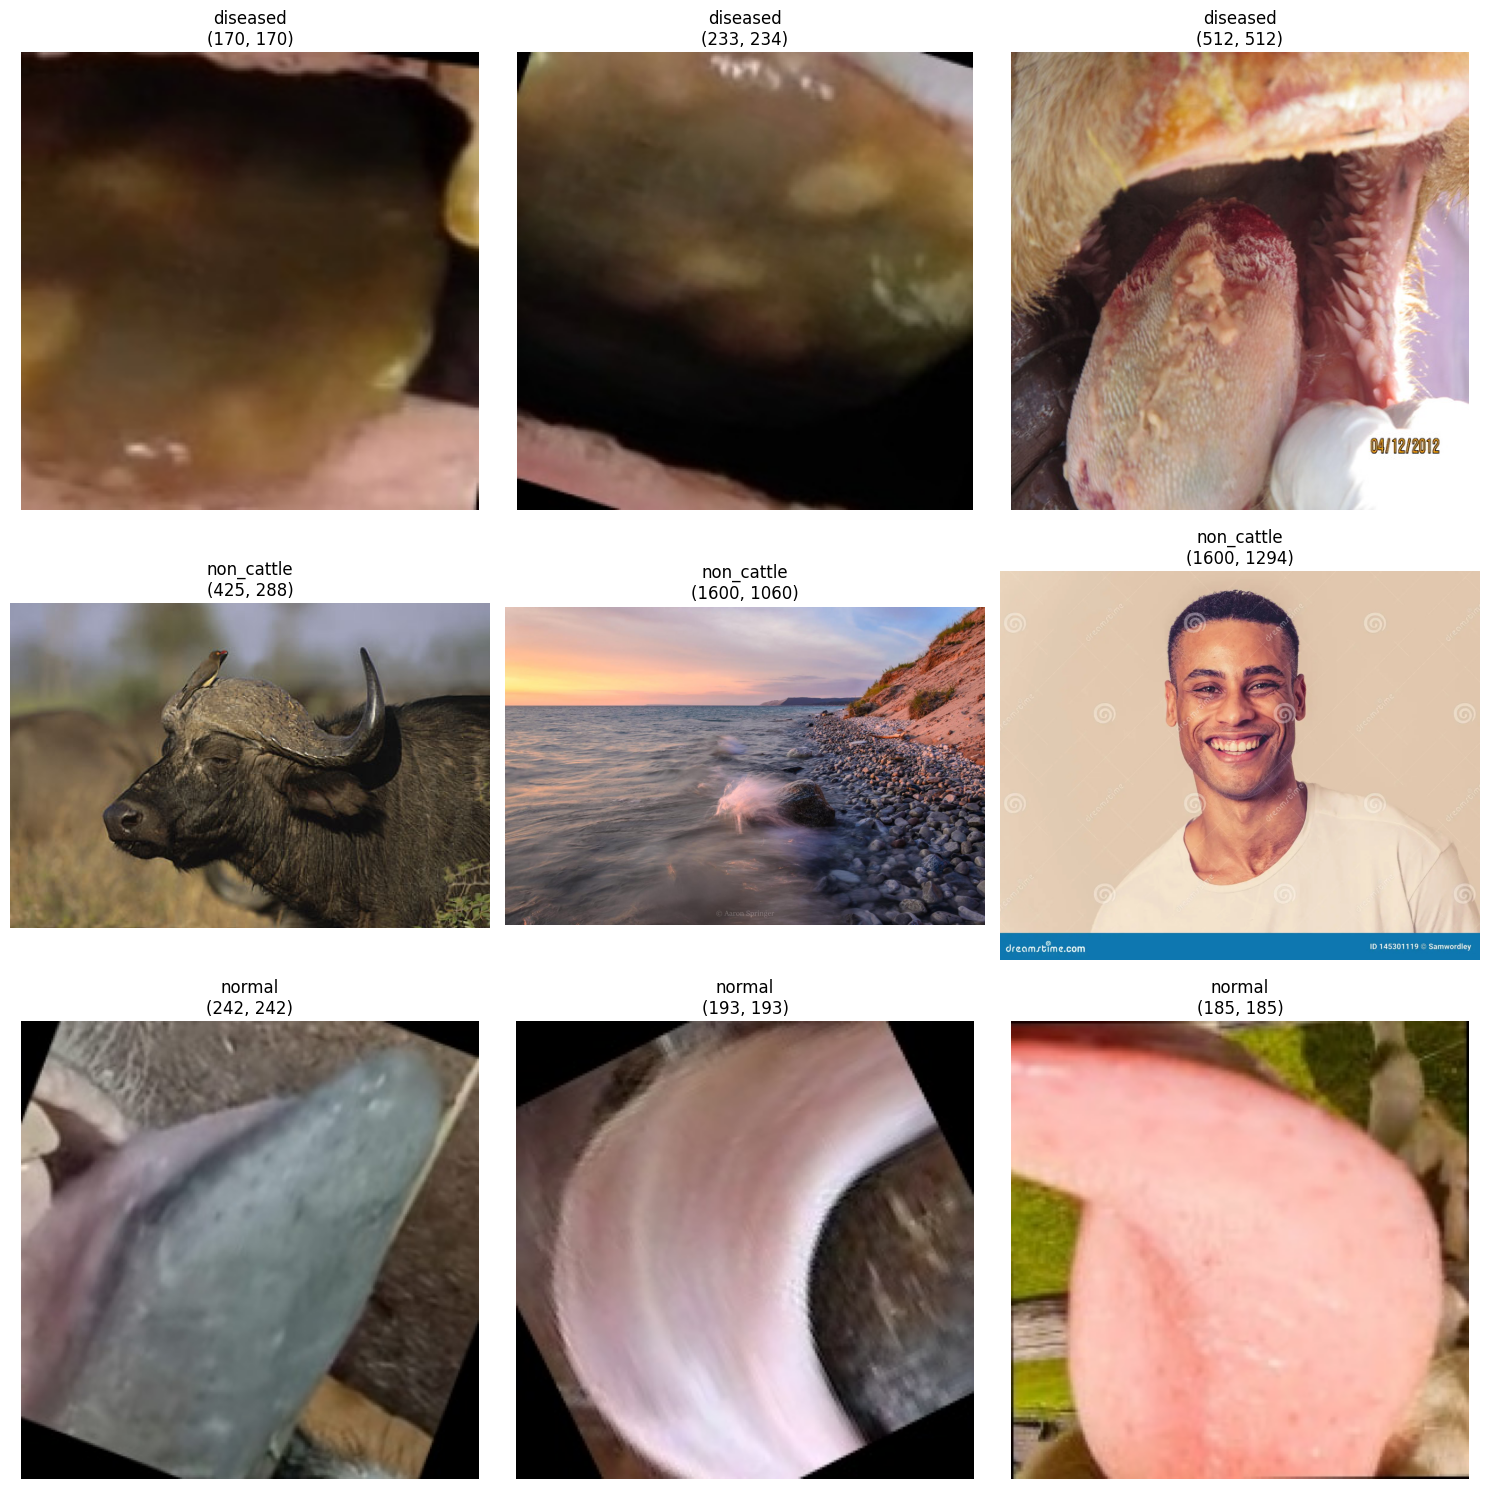

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np

def visualize_samples_fixed(dataset_path, num_samples=3):
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    if not classes:
        print("No classes found in dataset!")
        return

    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 5 * len(classes)))

    # Handle single class case
    if len(classes) == 1:
        axes = axes.reshape(1, -1)

    for i, class_name in enumerate(sorted(classes)):
        class_path = os.path.join(dataset_path, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

        if not images:
            print(f"No images found in {class_name}")
            continue

        sample_images = random.sample(images, min(num_samples, len(images)))

        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)
                ax = axes[i, j] if len(classes) > 1 else axes[j]
                ax.imshow(img)
                ax.set_title(f'{class_name}\n{img.size}')
                ax.axis('off')
                img.close()
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    plt.tight_layout()
    plt.show()

# Test the visualization
visualize_samples_fixed(processed_path)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Data preparation
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Check if we have enough data
classes = sorted([d for d in os.listdir(processed_path) if os.path.isdir(os.path.join(processed_path, d))])
NUM_CLASSES = len(classes)

print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {classes}")

if NUM_CLASSES == 0:
    raise ValueError("No classes found in the dataset!")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2  # 80-20 split
)

# Validation data (only rescaling)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    processed_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    processed_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Number of classes: 3
Classes: ['diseased', 'non_cattle', 'normal']
Found 810 images belonging to 3 classes.
Found 200 images belonging to 3 classes.
Training samples: 810
Validation samples: 200
Class indices: {'diseased': 0, 'non_cattle': 1, 'normal': 2}


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def create_mobilenetv2_model(num_classes):
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze base model layers
    base_model.trainable = False

    # Add custom layers
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Create model
model = create_mobilenetv2_model(NUM_CLASSES)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

# Set up callbacks
checkpoint = ModelCheckpoint(
    'best_tongue_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train the model
print("Starting training...")
epochs = 30

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4723 - loss: 1.2127
Epoch 1: val_accuracy improved from -inf to 0.72000, saving model to best_tongue_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.4778 - loss: 1.2019 - val_accuracy: 0.7200 - val_loss: 1.1275 - learning_rate: 0.0010
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.8645 - loss: 0.4068
Epoch 2: val_accuracy improved from 0.72000 to 0.74500, saving model to best_tongue_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 737ms/step - accuracy: 0.8648 - loss: 0.4063 - val_accuracy: 0.7450 - val_loss: 1.2280 - learning_rate: 0.0010
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9114 - loss: 0.2980
Epoch 3: val_accuracy improved from 0.74500 to 0.76000, saving model to best_tongue_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 720ms/step - accuracy: 0.9117 - loss: 0.2973 - val_accuracy: 0.7600 - val_loss: 1.1560 - learning_rate: 0.0010
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.9345 - loss: 0.2060
Epoch 4: val_accuracy improved from 0.76000 to 0.76500, saving model to best_tongue_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 737ms/step - accuracy: 0.9342 - loss: 0.2063 - val_accuracy: 0.7650 - val_loss: 1.0651 - learning_rate: 0.0010
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9243 - loss: 0.2313
Epoch 5: val_accuracy did not improve from 0.76500
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 728ms/step - accuracy: 0.9249 - loss: 0.2300 - val_accuracy: 0.7650 - val_loss: 0.9201 - learning_rate: 0.0010
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9391 - loss: 0.1903
Epoch 6: val_accuracy improved from 0.76500 to 0.77000, saving model to best_tongue_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 709ms/step - accuracy: 0.9393 - loss: 0.1895 - val_accuracy: 0.7700 - val_loss: 0.8866 - learning_rate: 0.0010
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9709 - loss: 0.1315
Epoch 7: val_accuracy did not improve from 0.77000
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 733ms/step - accuracy: 0.9705 - loss: 0.1320 - val_accuracy: 0.7700 - val_loss: 0.8527 - learning_rate: 0.0010
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9494 - loss: 0.1523
Epoch 8: val_accuracy improved from 0.77000 to 0.77500, saving model to best_tongue_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 714ms/step - accuracy: 0.9496 - loss: 0.1518 - val_accuracy: 0.7750 - val_loss: 0.6579 - learning_rate: 0.0010
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.9655 - loss: 0.1117
Epoch 9: val_accuracy improved from 0.77500 to 0.78000, saving model to best_tongue_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 725ms/step - accuracy: 0.9654 - loss: 0.1120 - val_accuracy: 0.7800 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.9707 - loss: 0.1118
Epoch 10: val_accuracy did not improve from 0.78000
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 703ms/step - accuracy: 0.9708 - loss: 0.1117 - val_accuracy: 0.7800 - val_loss: 0.8064 - learning_rate: 0.0010
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9726 - loss: 0.0965
Epoch 11: val_accuracy improved from 0.78000 to 0.78500, saving model to best_tongue_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 738ms/step - accuracy: 0.9725 - loss: 0.0966 - val_accuracy: 0.7850 - val_loss: 0.7269 - learning_rate: 0.0010
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.9750 - loss: 0.0900
Epoch 12: val_accuracy did not improve from 0.78500
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 689ms/step - accuracy: 0.9750 - loss: 0.0901 - val_accuracy: 0.7850 - val_loss: 0.7410 - learning_rate: 0.0010
Epoch 13/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.9785 - loss: 0.0973
Epoch 13: val_accuracy did not improve from 0.78500
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 724ms/step - accuracy: 0.9787 - loss: 0.0969 - val_accuracy: 0.7800 - val_loss: 0.6312 - learning_rate: 0.0010
Epoch 14/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.9830 - loss: 0.0658
Epoch 14: val_accuracy improved from 0.78500 to 0.79000, saving model to best_tongue_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 737ms/step - accuracy: 0.9832 - loss: 0.0658 - val_accuracy: 0.7900 - val_loss: 0.7313 - learning_rate: 0.0010
Epoch 15/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.9719 - loss: 0.0921
Epoch 15: val_accuracy improved from 0.79000 to 0.79500, saving model to best_tongue_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 733ms/step - accuracy: 0.9720 - loss: 0.0918 - val_accuracy: 0.7950 - val_loss: 0.6667 - learning_rate: 0.0010
Epoch 16/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9857 - loss: 0.0592
Epoch 16: val_accuracy did not improve from 0.79500
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 707ms/step - accuracy: 0.9854 - loss: 0.0597 - val_accuracy: 0.7950 - val_loss: 0.6696 - learning_rate: 0.0010
Epoch 17/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9698 - loss: 0.0774
Epoch 17: val_accuracy did not improve from 0.79500
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 719ms/step - accuracy: 0.9699 - loss: 0.0772 - val_accuracy: 0.7850 - val_loss: 0.7934 - learning_rate: 0.0010
Epoch 18/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.9820 - loss: 0.0701
Epoch 18: val_accuracy did not improve from 0.79500

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 691ms/step - accuracy: 0.9818 - loss: 0.0704 - 

26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 716ms/step - accuracy: 0.9793 - loss: 0.0704 - val_accuracy: 0.8000 - val_loss: 0.6686 - learning_rate: 2.0000e-04
Epoch 20/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9771 - loss: 0.0876
Epoch 20: val_accuracy did not improve from 0.80000
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 697ms/step - accuracy: 0.9774 - loss: 0.0867 - val_accuracy: 0.8000 - val_loss: 0.6614 - learning_rate: 2.0000e-04
Epoch 21/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9895 - loss: 0.0478
Epoch 21: val_accuracy did not improve from 0.80000
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 748ms/step - accuracy: 0.9894 - loss: 0.0481 - val_accuracy: 0.7950 - val_loss: 0.7022 - learning_rate: 2.0000e-04
Epoch 22/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9858 - loss: 0.0691
Epoch 22: val_accuracy did not improve from 0.80000
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 696ms/step - accuracy: 0.9860 - loss: 0.0686 - val_accuracy: 0.8000 - val_loss: 0.6666 - learning_rate: 2.0000e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.8941 - loss: 0.3402
Validation Accuracy: 0.8000
Validation Loss: 0.6686


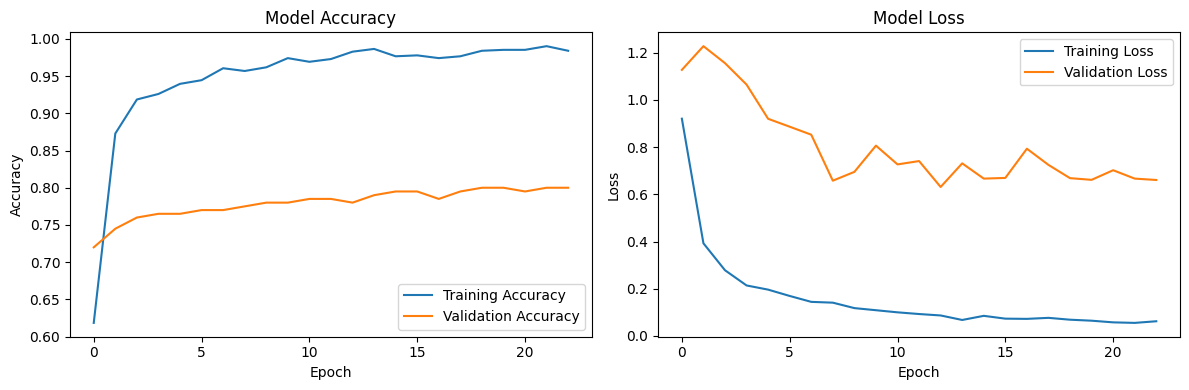

In [ ]:
# Load best model
model.load_weights('best_tongue_model.h5')

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the final model
model.save('tongue_classification_mobilenetv2.h5')
print("Model saved as 'tongue_classification_mobilenetv2.h5'")

# Save to Google Drive
try:
    model_save_path = '/content/drive/MyDrive/tongue_classification_mobilenetv2.h5'
    model.save(model_save_path)
    print(f"Model also saved to Google Drive: {model_save_path}")
except:
    print("Google Drive not mounted or save failed")

# Print class indices for reference
print("\nClass indices mapping:")
for class_name, index in train_generator.class_indices.items():
    print(f"{class_name}: {index}")

Model saved as 'tongue_classification_mobilenetv2.h5'
Model also saved to Google Drive: /content/drive/MyDrive/tongue_classification_mobilenetv2.h5

Class indices mapping:
diseased: 0
non_cattle: 1
normal: 2


In [ ]:
# Function to test predictions
def predict_tongue_image(image_path, model, class_indices):
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Get class name
    class_names = {v: k for k, v in class_indices.items()}
    predicted_class = class_names[predicted_class_idx]

    return predicted_class, confidence, predictions[0]

# Test with sample images from each class
class_indices = train_generator.class_indices
print("\nTesting predictions on sample images:")

for class_name in class_indices.keys():
    class_path = os.path.join(processed_path, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if images:
        sample_image = os.path.join(class_path, images[0])
        predicted_class, confidence, all_probs = predict_tongue_image(sample_image, model, class_indices)

        print(f"\nTrue: {class_name}")
        print(f"Predicted: {predicted_class}")
        print(f"Confidence: {confidence:.4f}")

        # Show probabilities for all classes
        for cls_idx, prob in enumerate(all_probs):
            cls_name = list(class_indices.keys())[cls_idx]
            print(f"  {cls_name}: {prob:.4f}")


Testing predictions on sample images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

True: diseased
Predicted: diseased
Confidence: 0.9758
  diseased: 0.9758
  non_cattle: 0.0157
  normal: 0.0085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

True: non_cattle
Predicted: non_cattle
Confidence: 0.9532
  diseased: 0.0435
  non_cattle: 0.9532
  normal: 0.0032
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

True: normal
Predicted: normal
Confidence: 0.9997
  diseased: 0.0003
  non_cattle: 0.0000
  normal: 0.9997


In [ ]:
!pip install gradio
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

# Load your trained model
model = tf.keras.models.load_model('tongue_classification_mobilenetv2.h5')
print("Model loaded successfully!")

# Define class names based on your training
class_names = ['diseased', 'non_cattle', 'normal']  # Adjust based on your actual class order
print("Class names:", class_names)

# Image size for model input
IMG_SIZE = (224, 224)

def preprocess_image(image):
    """
    Preprocess the image for model prediction
    """
    # Convert to RGB if needed
    if isinstance(image, np.ndarray):
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = Image.fromarray(image.astype('uint8'), 'RGB')
        elif len(image.shape) == 2:
            image = Image.fromarray(image.astype('uint8'), 'L').convert('RGB')

    # Resize image
    image = image.resize(IMG_SIZE)

    # Convert to array and normalize
    img_array = np.array(image) / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

def predict_tongue(image):
    """
    Make prediction on the input image
    """
    try:
        # Preprocess image
        processed_image = preprocess_image(image)

        # Make prediction
        predictions = model.predict(processed_image, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = np.max(predictions[0])
        predicted_class = class_names[predicted_class_idx]

        # Get all probabilities
        probabilities = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}

        return predicted_class, confidence, probabilities

    except Exception as e:
        return f"Error: {str(e)}", 0.0, {}

def create_visualization(image, prediction, confidence, probabilities):
    """
    Create a visualization of the prediction results
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Show original image
    ax1.imshow(image)
    ax1.set_title(f'Input Image\nPredicted: {prediction} ({confidence:.2%})')
    ax1.axis('off')

    # Show probability bar chart
    classes = list(probabilities.keys())
    probs = list(probabilities.values())

    colors = ['red' if cls == prediction else 'blue' for cls in classes]
    bars = ax2.barh(classes, probs, color=colors)
    ax2.set_xlim(0, 1)
    ax2.set_xlabel('Probability')
    ax2.set_title('Classification Probabilities')
    ax2.grid(axis='x', alpha=0.3)

    # Add probability values on bars
    for bar, prob in zip(bars, probs):
        width = bar.get_width()
        ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{prob:.3f}', ha='left', va='center')

    plt.tight_layout()
    return fig

def gradio_predict(input_image):
    """
    Main prediction function for Gradio
    """
    # Make prediction
    prediction, confidence, probabilities = predict_tongue(input_image)

    # Create visualization
    fig = create_visualization(input_image, prediction, confidence, probabilities)

    # Format results
    result_text = f"**Prediction:** {prediction}\n**Confidence:** {confidence:.2%}"

    # Detailed probabilities
    prob_text = "**Detailed Probabilities:**\n"
    for cls, prob in probabilities.items():
        prob_text += f"- {cls}: {prob:.3f}\n"

    return result_text + "\n\n" + prob_text, fig

# Create Gradio interface
def create_gradio_interface():
    with gr.Blocks(theme=gr.themes.Soft(), title="Tongue Classification") as demo:
        gr.Markdown(
            """
            # 🐄 Cattle Tongue Classification
            ### Classify tongue images as Diseased, Normal, or Non-Cattle
            Upload an image of a cattle tongue to classify it using our MobileNetV2 model.
            """
        )

        with gr.Row():
            with gr.Column():
                image_input = gr.Image(
                    type="pil",
                    label="Upload Tongue Image",
                    sources=["upload", "webcam"],
                    height=300
                )

                submit_btn = gr.Button("Classify Image", variant="primary")

                examples = gr.Examples(
                    examples=[
                        # You can add example image paths here
                        # "/content/processed_tongue_dataset/diseased/sample1.jpg",
                        # "/content/processed_tongue_dataset/normal/sample1.jpg",
                        # "/content/processed_tongue_dataset/non_cattle/sample1.jpg"
                    ],
                    inputs=image_input,
                    label="Example Images (if available)"
                )

            with gr.Column():
                output_text = gr.Textbox(
                    label="Classification Results",
                    lines=8,
                    max_lines=10
                )

                output_plot = gr.Plot(
                    label="Probability Visualization"
                )

        # Additional information
        with gr.Accordion("Model Information", open=False):
            gr.Markdown(
                """
                **Model Details:**
                - Architecture: MobileNetV2
                - Input Size: 224x224 pixels
                - Classes: Diseased, Normal, Non-Cattle
                - Training: Transfer Learning with ImageNet weights

                **Instructions:**
                1. Upload a clear image of a cattle tongue
                2. Click 'Classify Image'
                3. View the prediction results and probabilities

                **Note:** For best results, use clear, well-lit images focused on the tongue.
                """
            )

        # Set up the prediction function
        submit_btn.click(
            fn=gradio_predict,
            inputs=image_input,
            outputs=[output_text, output_plot]
        )

        # Also predict on image change
        image_input.upload(
            fn=gradio_predict,
            inputs=image_input,
            outputs=[output_text, output_plot]
        )

    return demo

# Create and launch the interface
demo = create_gradio_interface()

# Launch the interface
print("Launching Gradio interface...")
demo.launch(share=True)

Model loaded successfully!
Class names: ['diseased', 'non_cattle', 'normal']
Launching Gradio interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e4c6a07ae1801c5cef.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Complete download package for Flask app
import json
import pickle
import numpy as np
from google.colab import files

def create_flask_package():
    """Create all necessary files for Flask deployment"""

    # 1. Download the model
    print("1. Downloading model file...")
    files.download('tongue_classification_mobilenetv2.h5')

    # 2. Create and download class information
    print("2. Creating class information files...")

    # Get class info from your training
    class_indices = train_generator.class_indices
    class_names = list(class_indices.keys())

    # Save as JSON
    class_info = {
        'class_indices': class_indices,
        'class_names': class_names,
        'img_size': [224, 224]  # Model input size
    }

    with open('model_config.json', 'w') as f:
        json.dump(class_info, f, indent=4)

    files.download('model_config.json')

    # 3. Create requirements.txt for Flask app
    print("3. Creating requirements.txt...")
    requirements = [
        "tensorflow==2.13.0",
        "keras==2.13.1",
        "numpy==1.24.3",
        "pillow==10.0.0",
        "flask==2.3.3",
        "flask-cors==4.0.0",
        "opencv-python==4.8.1.78",
        "matplotlib==3.7.2",
        "scikit-learn==1.3.0"
    ]

    with open('requirements.txt', 'w') as f:
        f.write('\n'.join(requirements))

    files.download('requirements.txt')

    # 4. Create a simple test script
    print("4. Creating test script...")
    test_script = '''
import tensorflow as tf
import numpy as np
from PIL import Image
import json

def load_model_and_config():
    """Load model and configuration"""
    model = tf.keras.models.load_model('tongue_classification_mobilenetv2.h5')

    with open('model_config.json', 'r') as f:
        config = json.load(f)

    return model, config

def predict_image(image_path, model, config):
    """Predict a single image"""
    # Load and preprocess image
    img = Image.open(image_path)
    img = img.resize(config['img_size'])
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Get class name
    class_names = config['class_names']
    predicted_class = class_names[predicted_class_idx]

    return predicted_class, confidence

# Test the function
if __name__ == "__main__":
    model, config = load_model_and_config()
    print("Model loaded successfully!")
    print(f"Classes: {config['class_names']}")
'''

    with open('test_model.py', 'w') as f:
        f.write(test_script)

    files.download('test_model.py')

# Run the package creation
create_flask_package()

1. Downloading model file...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2. Creating class information files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3. Creating requirements.txt...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4. Creating test script...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>